In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from fastai.vision.all import PILImage

print(torch.__version__)
print(torchvision.__version__)

2.4.1+cpu
0.19.1+cpu


#### Loading and Display MNIST Data

In [2]:
dataset = torchvision.datasets.MNIST(root='./data', download=True)

print(f"Dataset size: {len(dataset)}")
print(f"First data point (image, label): {dataset[0]}")
PILImage.create(dataset[0][0])


Dataset size: 60000
First data point (image, label): (<PIL.Image.Image image mode=L size=28x28>, 5)


#### Data Pre-Processing

In [3]:
transform = transforms.Compose([    
    transforms.ToTensor(),
    transforms.RandomAffine(60, translate=(0.1, 0.1)),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1)),
    transforms.GaussianBlur(kernel_size=5)
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip()
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

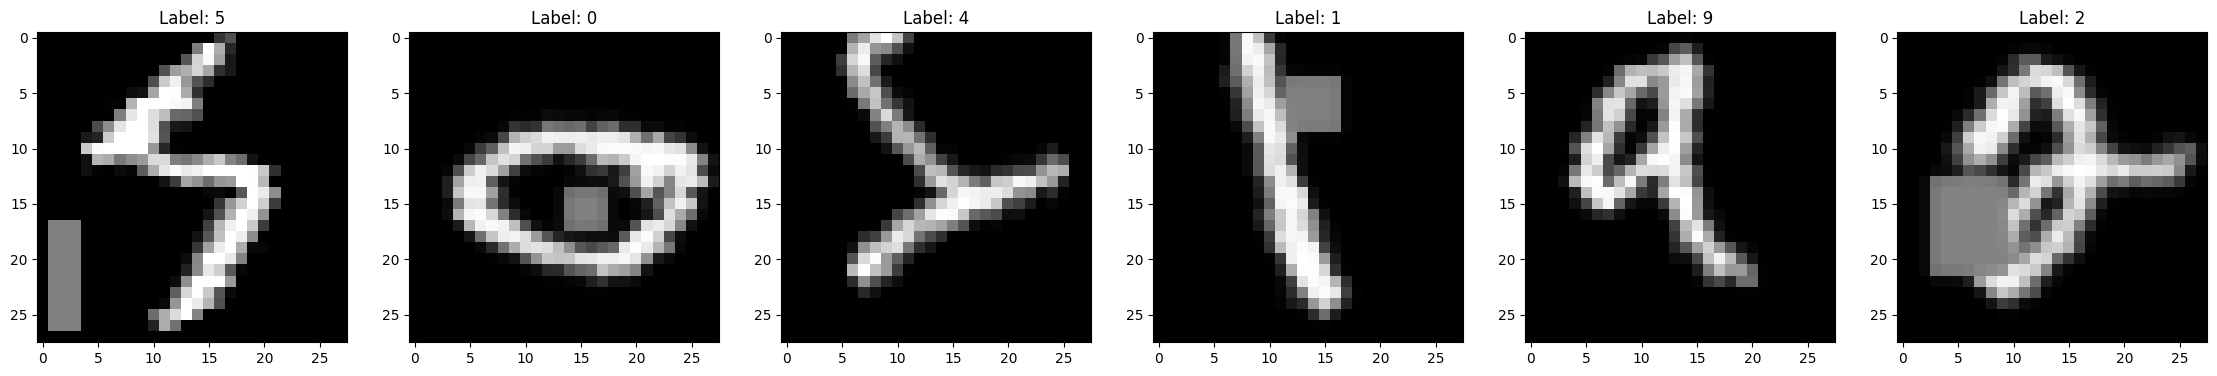

In [5]:
def show_images(images, labels):
    fig, axes = plt.subplots(1, 6, figsize=(28, 28))
    
    for i in range(6):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {labels[i]}')
    plt.show()

data_iter = iter(train_dataloader)
images, labels = next(data_iter)

show_images(images, labels)

#### Train the Model

In [24]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.bn1 = nn.BatchNorm1d(128) 
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64) 
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.bn1(self.fc1(x)))  
        x = self.relu(self.bn2(self.fc2(x)))  
        x = self.softmax(self.fc3(x))
        return x

In [40]:
model = MLP()
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.0028)

In [1]:
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for images, labels in train_dataloader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

Epoch [1/30], Loss: 1.0548
Epoch [2/30], Loss: 0.7382
Epoch [3/30], Loss: 0.6504
Epoch [4/30], Loss: 0.5940
Epoch [5/30], Loss: 0.5571
Epoch [6/30], Loss: 0.5281
Epoch [7/30], Loss: 0.5103
Epoch [8/30], Loss: 0.4925
Epoch [9/30], Loss: 0.4773
Epoch [10/30], Loss: 0.4674
Epoch [11/30], Loss: 0.4565
Epoch [12/30], Loss: 0.4420
Epoch [13/30], Loss: 0.4441
Epoch [14/30], Loss: 0.4362
Epoch [15/30], Loss: 0.4257
Epoch [16/30], Loss: 0.4201
Epoch [17/30], Loss: 0.4122
Epoch [18/30], Loss: 0.4070
Epoch [19/30], Loss: 0.4060
Epoch [20/30], Loss: 0.3940
Epoch [21/30], Loss: 0.3930
Epoch [22/30], Loss: 0.3945
Epoch [23/30], Loss: 0.3913
Epoch [24/30], Loss: 0.3846
Epoch [25/30], Loss: 0.3874
Epoch [26/30], Loss: 0.3763
Epoch [27/30], Loss: 0.3832
Epoch [28/30], Loss: 0.3732
Epoch [29/30], Loss: 0.3744
Epoch [30/30], Loss: 0.3669


In [2]:
model.eval()
total_test_loss = 0.0
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for test_images, test_labels in test_dataloader:
        test_outputs = model(test_images)
        test_loss = criterion(test_outputs, test_labels)
        total_test_loss += test_loss.item()
        
        _, predicted = torch.max(test_outputs, 1)
        correct_predictions += (predicted == test_labels).sum().item()
        total_samples += test_labels.size(0)

avg_test_loss = total_test_loss / len(test_dataloader)
error_rate = 1 - (correct_predictions / total_samples)

print(f"Testing Loss: {avg_test_loss:.4f}")
print(f"Error Rate: {error_rate * 100:.2f}%")

Testing Loss: 0.3348
Error Rate: 10.78%


In [37]:
test_images, test_labels = next(iter(test_dataloader))
with torch.no_grad():
    test_outputs = model(test_images)
    _, predicted = torch.max(test_outputs, 1)

print(f'Predicted: {predicted[:12]}')
print(f'Actual:    {test_labels[:12]}')

Predicted: tensor([3, 3, 5, 9, 2, 0, 2, 2, 9, 7, 1, 6])
Actual:    tensor([3, 3, 5, 9, 2, 0, 9, 2, 7, 7, 1, 6])


#### Saving the Model

In [38]:
torch.save(model.state_dict(), 'model.pth')

#### Loading the Saved Model

In [14]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten() 
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)    
        self.fc3 = nn.Linear(64, 10)  
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x
    
model = MLP()

model.load_state_dict(torch.load('model.pth'))

C:\Users\KIIT\AppData\Local\Temp\ipykernel_30080\1104402647.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


<All keys matched successfully>